# Read Data

In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import pandas as pd

dataset = pd.read_parquet('Metal_all_20180116.snappy.parquet', engine='pyarrow')

# credit: https://github.com/zygmuntz/classifying-text
# FOFE package for encoding protein sequences with variable lengths into fixed length

from fofePackage.fofe.fofe import FofeVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
import numpy as np

# Pre-process Data
### 1. Eliminate X and U
### 2. Apply a cut-off to the dataset

In [2]:
proteinSet = dataset.as_matrix(columns=None)

# sequence set
sequenceSet = proteinSet[:,[4]]

# fingerprint set
fingerPrintSet = proteinSet[:,[2]]

# helper methods for extracting sequence set and fingerprint set for a specific ligandID
# return: 1: fingerPrintSet for a ligandID; 2: sequenceSet for a ligandID

def extractOneLigandID(id):
    extractedSet = proteinSet[proteinSet[:,1]==id]
    return extractedSet[:,[2]].tolist(), extractedSet[:,[4]].tolist()

fpLs_zn, seqLs_zn = extractOneLigandID("ZN")

# sequence list where each sequence is a list of symbols

seq_ls = []

for i in seqLs_zn:
    sb_ls = []
    for j in i[0]:
        sb_ls.append(j)
    seq_ls.append(sb_ls)
    
# eliminate X and U

def eliXAndU(sqls, fpls):
    print("size of sequence set before eliminating X and U: "+str(len(sqls)))
    sq_out = []
    fp_out = []
    for i in range(len(sqls)):
        invalidSeq = False
        for j in sqls[i]:
            if j =='X' or j == 'U':
                invalidSeq = True
                break
        if invalidSeq == False:
            sq_out.append(sqls[i])
            fp_out.append(fpls[i])
            
    print("size of sequence set after eliminating X and U: "+str(len(sq_out)))
    return sq_out, fp_out    

seq_ls_eli, fp_ls_eli = eliXAndU(seq_ls, fpLs_zn)
#seq_ls_eli, fp_ls_eli = seq_ls, fpLs_zn

# make a list that stores all lengths for all sequence to make a cut-off

length_ls = []

for i in seq_ls_eli:
    curLen = 0
    for j in i:
        curLen +=1
    
    length_ls.append(curLen)
    
# helper function to get a sub list of current sequence list and foot print list

def getSubList(sqls, fpls, cutoff):
    sq_out = []
    fp_out = []
    for i in range(len(sqls)):
        if len(sqls[i]) <= cutoff:
            sq_out.append(sqls[i])
            fp_out.append(fpls[i])
    
    return sq_out, fp_out


# sort length list to do a cut-off
length_ls.sort()
length_ls = np.array(length_ls)

stdLength = np.std(length_ls, dtype=np.float32)
meanLength = np.mean(length_ls, dtype=np.float32)

print("std: "+str(stdLength)+" mean: "+str(meanLength))


# do cut-off
seq_ls_cut, fp_ls_cut = getSubList(seq_ls_eli, fp_ls_eli, meanLength+2*stdLength)



# don't do cut-off
# seq_ls_cut = seq_ls
# fp_ls_cut = fpLs_zn

print("size of sequence set before cutoff: "+str(len(seq_ls_eli)))
print("size of sequence set after cutoff: "+str(len(seq_ls_cut)))

# find the max length of sequences after cut off
maxLength = 0

for i in seq_ls_cut:
    curLen = 0
    for j in i:
        curLen +=1
    
    if curLen>maxLength:
        maxLength = curLen
print("maxLength after cutoff is: " + str(maxLength))



size of sequence set before eliminating X and U: 23277
size of sequence set after eliminating X and U: 23233
std: 200.986 mean: 306.67
size of sequence set before cutoff: 23233
size of sequence set after cutoff: 22207
maxLength after cutoff is: 707


In [3]:
# C & H take 37% in all sequences and 81% in sequences with zinc binding
C_H_count = 0
total_binding_sites = 0

for i in range(len(sequenceSet)):
    for j in fingerPrintSet[i][0]:
        if sequenceSet[i][0][j]== "C" or sequenceSet[i][0][j] == "H":
            C_H_count+=1
        total_binding_sites+=1

print("C and H takes: "+str(C_H_count/total_binding_sites))
        

C_H_count_zn = 0
total_binding_sites_zn = 0

for i in range(len(seq_ls_cut)):
    for j in fp_ls_cut[i][0]:
        if seq_ls_cut[i][j] == "C" or seq_ls_cut[i][j] == "H":
            C_H_count_zn+=1
        total_binding_sites_zn+=1

print("C and H in zinc binding sequences takes: "+str(C_H_count_zn/total_binding_sites_zn))

C and H takes: 0.3700922303760601
C and H in zinc binding sequences takes: 0.8088663790408304


In [4]:
full_seq_ls = []

for i in seq_ls_cut:
    full_seq_ls.append("".join(i))

# Prepare parameters for FOFE encoding

In [5]:
# pre-process seq_ls_cut to make it a 2-gram dataset: ABC -> AB, BC
two_gram_ls = []

for i in seq_ls_cut:
    cur_two_gram = []
    for j in range(len(i)-1):
        cur_two_gram.append(i[j]+i[j+1])
    two_gram_ls.append(cur_two_gram)

seq_ls_cut = two_gram_ls

In [6]:
# a dict to find out what 2-gram types the sequences have
# Ignore X and U symbols
symbolDict = {}
for i in seq_ls_cut:
    for j in i:
            symbolDict[j] = 1

# vocabulary: a dictionary mapping symbols (amino acid) to indices

# raw_doc: list of all symbols
raw_doc = []

for key, _ in symbolDict.items():
    raw_doc.append(key)

    
# # # Marker B
# raw_doc.append('B')
    
# create the vocabulary dictionary
vocab_dict = {}
count = 0
for sb in raw_doc:
    vocab_dict[sb] = count
    count +=1

In [7]:
# # insert marker symbol "B" to the beginning of all sequences

# for i in range(len(seq_ls_cut)):
#     seq_ls_cut[i] = ['B']+seq_ls_cut[i]
    
# # increase all finger print data by 1

# fp_ls_inc_by_1 = []

# for i in range(len(fp_ls_cut)):
#     cur_fp_ls = np.array([])
#     for j in range(len(fp_ls_cut[i][0])):
#         cur_fp_ls = np.append(cur_fp_ls, np.array([fp_ls_cut[i][0][j]+1])).astype(int)
#     fp_ls_inc_by_1.append([cur_fp_ls])

# fp_ls_cut = fp_ls_inc_by_1

In [8]:
# BUILD of a simple CNN architecture
import tensorflow as tf
import time
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Reshape, Embedding, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD
import numpy as np
import keras

Using TensorFlow backend.


In [9]:
# helper function to find the ranking of finger print points in prediction
def getF1(sequence_index, label_set, pred, factor):
    
    prob_mean = np.mean(pred[sequence_index])
    prob_std = np.std(pred[sequence_index])
    
    prob_th = prob_mean+factor*prob_std
    
    cur_fp_ls = label_set[sequence_index][0]
    truePositive = 0
    falseNegative = 0
    for i in range(len(cur_fp_ls)):
        cur_index = cur_fp_ls[i]
        if pred[sequence_index][cur_index] >= prob_th:
            truePositive += 1
        else:
            falseNegative += 1
    
    Positive = 0
    Negative = 0
    for i in range(len(pred[sequence_index])):
        if pred[sequence_index][i] >= prob_th:
            Positive += 1
        else:
            Negative += 1
                
    return truePositive, falseNegative, Positive, Negative

In [10]:
def getF1_new(sequence_index, label_set, pred, factor):
    
    prob_mean = np.mean(pred[sequence_index])
    prob_std = np.std(pred[sequence_index]) 
    prob_th = prob_mean+factor*prob_std
    cur_fp_ls = label_set[sequence_index]
    truePositive = 0
    falseNegative = 0
    falsePositive = 0
    for i in range(len(cur_fp_ls)):
        if(cur_fp_ls[i] == 1):
            if pred[sequence_index][i] >= prob_th:
                truePositive += 1
            else:
                falseNegative += 1
        else:
            if pred[sequence_index][i] >= prob_th and cur_fp_ls[i] == 0:
                falsePositive += 1
    
    Positive = 0
    Negative = 0
    for i in range(len(pred[sequence_index])):
        if pred[sequence_index][i] >= prob_th:
            Positive += 1
        else:
            Negative += 1
            
    return truePositive, falseNegative, Positive, Negative

In [11]:
# helper function to find the ranking of finger print points in prediction
def getRanking(sequence_index, label_set, pred):
    # build a list of tuples based on the prediction list
    tuple_ls = []
    for i in range(len(pred[sequence_index])):
        tuple_ls.append((i, pred[sequence_index][i]))
    
    tuple_ls = sorted(tuple_ls, key=lambda x: x[1], reverse=True)
    
    output_ls = []
    cur_fp_ls = label_set[sequence_index][0]
    
    #print(cur_fp_ls)
    for i in range(len(cur_fp_ls)):
        
        cur_index = cur_fp_ls[i]
        for j in range(len(tuple_ls)):
            if tuple_ls[j][0]==cur_index:
                output_ls.append(j+1)
                #print("Ranking for site "+str(cur_index)+" is: "+str(j+1))
                
    return output_ls

In [12]:
# For hybrid model only
def random_sample_n_times(X, Y, size):
    X1 = X
    n = X1.shape[0]
    _X1, _Y = [], []
    for i in range(size):
        r = np.random.randint(n)
        _X1.append(X1[r].tolist())
        _Y.append(Y[r].tolist())
        
    _X = np.asarray(_X1)
    _Y = np.asarray(_Y)
    
    return _X, _Y

In [13]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

class custom_callback(Callback):
    def __init__(self,training_data,validation_data, sample_size):
        self.sample_size = sample_size

        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        
        self.roc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        

    def on_train_begin(self, logs={}):
        self.roc_scores = []
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []
        return
    
    def on_epoch_end(self, epoch, logs={}):
        x, y = random_sample_n_times(self.x, self.y, self.sample_size)
        x_val, y_val = random_sample_n_times(self.x_val, self.y_val, self.sample_size)

        y_pred = self.model.predict(x)
        y_pred_val = self.model.predict(x_val)
    
        tp_sum = 0
        fn_sum = 0
        p_sum = 0
        n_sum = 0
        
        # calculate f1 score in the batch from validation set
        for i in range(self.sample_size):
            tp,fn,p,n = getF1_new(i, y_val, y_pred_val,4)
            tp_sum = tp_sum + tp
            fn_sum = fn_sum + fn
            p_sum = p_sum + p
            n_sum = n_sum + n

        precision = tp_sum/p_sum
        recall = tp_sum/(tp_sum+fn_sum) 
        f1 = 2*precision*recall/(precision+recall)

        self.f1_scores.append((len(self.f1_scores),f1))
        
        return
        
        


In [20]:
# look at all sequences and create key value pair for duplicate sequences and respective fp
seq_dict = {}

for i in range(len(seqLs_zn)):
    if seqLs_zn[i][0] in seq_dict:
        for j in range(fpLs_zn[i][0].size):
            seq_dict[seqLs_zn[i][0]][fpLs_zn[i][0][j]] = 1
    else:
        seq_dict[seqLs_zn[i][0]] = {}
        for j in range(fpLs_zn[i][0].size):
            seq_dict[seqLs_zn[i][0]][fpLs_zn[i][0][j]] = 1



In [22]:
seq_dict

{'TPEMPVLENRAAQGDITAPGGARRLTGDQTAALRDSLSDKPAKNIILLIGDGMGDSEITAARNYAEGAGGFFKGIDALPLTGQYTHYALNKKTGKPDYVTDSAASATAWSTGVKTYNGALGVDIHEKDHPTILEMAKAAGLATGNVSTAELQGATPAALVAHVTSRKCYGPSATSEKCPGNALEKGGKGSITEQLLNARADVTLGGGAKTFAETATAGEWQGKTLREQAEARGYQLVSDAASLNSVTEANQQKPLLGLFADGNMPVRWLGPKATYHGNIDKPAVTCTPNPQRNDSVPTLAQMTDKAIELLSKNEKGFFLQVEGASIDKQDHAANPCGQIGETVDLDEAVQRALEFAKKEGNTLVIVTADHAHASQIVAPDTKAPGLTQALNTKDGAVMVMSYGNSEEDSQEHTGSQLRIAAYGPHAANVVGLTDQTDLFYTMKAALGLK': {50: 1,
  101: 1,
  326: 1,
  330: 1,
  368: 1,
  369: 1,
  411: 1},
 'MHPRFQTAFAQLADNLQSALEPILADKYFPALLTGEQVSSLKSATGLDEDALAFALLPLAAACARTPLSNFNVGAIARGVSGTWYFGANMEFIGATMQQTVHAEQSAISHAWLSGEKALAAITVNYTPCGHCRQFMNELNSGLDLRIHLPGREAHALRDYLPDAFGPKDLEIKTLLMDEQDHGYALTGDALSQAAIAAANRSHMPYSKSPSGVALECKDGRIFSGSYAENAAFNPTLPPLQGALILLNLKGYDYPDIQRAVLAEKADAPLIQWDATSATLKALGCHSIDRVLLA': {101: 1,
  128: 1,
  131: 1},
 'ALAQKRDNVLFQAATDEQPAVIKTLEKLVNIETGTGDAEGIAAAGNFLEAELKNLGFTVTRSKSAGLVVGDNIVGKIKGRGGKNLLLMSHMDTVYLKGILAKAPFRVEGDKAYGPGIADDKGGNAVILHTLKLLKEYGVRDYGTIT

In [31]:
seq_dict[full_seq_ls[int(len(full_seq_ls)*3/4)]]

{188: 1, 190: 1, 234: 1, 240: 1, 276: 1, 306: 1, 308: 1}

In [34]:
def buildFeatureAndTrain(alpha,factor):

    print("alpha = "+str(alpha))
    #alpha = 1 - 1e-3
    #alpha = 0.4

    fofe = FofeVectorizer(alpha)

    # naive transform: slow and memory hungry, but is readable
    features = fofe.naive_transform(seq_ls_cut, vocab_dict)
    labels = fp_ls_cut[:]

    # get reverse of sequences
    seq_ls_cut_rev = []
    for i in seq_ls_cut:
        seq_ls_cut_rev.append(list(reversed(i)))
    features_rev = fofe.naive_transform(seq_ls_cut_rev, vocab_dict)

    # normalize feature matrix by subtracting each value by mean/std
    for i in range(len(features)):
        tmp_ls = np.array(features[i])
        tmp_std = np.std(tmp_ls, dtype=np.float32)
        tmp_mean = np.mean(tmp_ls, dtype=np.float32)
        for j in range(len(tmp_ls)):
            features[i][j]=tmp_ls[j]-tmp_mean/tmp_std

    # normalize feature matrix by subtracting each value by mean/std
    for i in range(len(features_rev)):
        tmp_ls = np.array(features_rev[i])
        tmp_std = np.std(tmp_ls, dtype=np.float32)
        tmp_mean = np.mean(tmp_ls, dtype=np.float32)
        for j in range(len(tmp_ls)):
            features_rev[i][j]=tmp_ls[j]-tmp_mean/tmp_std

    # Combine features and features_rev
    features_new = []
    for i in range(len(features)):
        features_new.append(np.concatenate((features[i],features_rev[i])))

    features = features_new
    #print(features_new[0])


    train_features = features[:int(len(features)*3/4)]
    train_labels = labels[:int(len(labels)*3/4)]
    
    vali_features = features[int(len(features)*3/4):int(len(features)*7/8)]
    vali_labels = labels[int(len(labels)*3/4):int(len(labels)*7/8)]

    test_features = features[int(len(features)*7/8):]
    test_labels = labels[int(len(labels)*7/8):]

    train_seq_ls_cut = seq_ls_cut[:int(len(seq_ls_cut)*3/4)]
    vali_seq_ls_cut = seq_ls_cut[int(len(seq_ls_cut)*3/4):int(len(seq_ls_cut)*7/8)]
    test_seq_ls_cut = seq_ls_cut[int(len(seq_ls_cut)*7/8):]

    train_fp_ls_cut = fp_ls_cut[:int(len(fp_ls_cut)*3/4)]
    vali_fp_ls_cut = fp_ls_cut[int(len(fp_ls_cut)*3/4):int(len(fp_ls_cut)*7/8)]
    test_fp_ls_cut = fp_ls_cut[int(len(fp_ls_cut)*7/8):] 
    
    train_full_seq_ls = full_seq_ls[:int(len(full_seq_ls)*3/4)]
    vali_full_seq_ls = full_seq_ls[int(len(full_seq_ls)*3/4):int(len(full_seq_ls)*7/8)]
    test_full_seq_ls = full_seq_ls[int(len(full_seq_ls)*7/8):]

    train_features = np.array(train_features)
    vali_features = np.array(vali_features)
    test_features = np.array(test_features)
    
    # get test_labels and vali_labels combined for duplicate sequences
    for i in range(len(vali_seq_ls_cut)):
        for cur_fp in seq_dict[vali_full_seq_ls[i]]:
            if cur_fp not in vali_labels[i][0]:
                vali_labels[i][0] = np.append(vali_labels[i][0], [cur_fp]) 
        
        
    for i in range(len(test_seq_ls_cut)):
        for cur_fp in seq_dict[test_full_seq_ls[i]]:
            if cur_fp not in test_labels[i][0]:
                test_labels[i][0] = np.append(test_labels[i][0], [cur_fp])       

    #prep of labels
    #create zero matrix of all zeros with maxLength columns
    train_l = np.zeros((len(train_labels),maxLength))
    vali_l = np.zeros((len(vali_labels),maxLength))
    test_l = np.zeros((len(test_labels),maxLength))

    for i in range(len(train_labels)):
        for j in train_labels[i][0]:
            train_l[i][j] = 1

    for i in range(len(vali_labels)):
        for j in vali_labels[i][0]:
            vali_l[i][j] = 1
            
    for i in range(len(test_labels)):
        for j in test_labels[i][0]:
            test_l[i][j] = 1    
            
    print(vali_l[0])
            

    train_l = np.array(train_l)
    vali_l = np.array(vali_l)
    test_l = np.array(test_l)
    
    #The MODEL
    #3 parallel conv2d layers
    
    fofe_input = Input(shape=(800,), dtype='float32', name='fofe_input')
    fofe_input_reshape = Reshape((1,800,1), input_shape=(800,))(fofe_input)
    conv2d_3 = Convolution2D(3, 1, 6, border_mode='same')(fofe_input_reshape)
    conv2d_5 = Convolution2D(5, 1, 4, border_mode='same')(fofe_input_reshape)
    conv2d_7 = Convolution2D(7, 1, 2, border_mode='same')(fofe_input_reshape)
    
    x = keras.layers.concatenate([conv2d_3,conv2d_5,conv2d_7])
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(maxLength, activation='relu')(x)
    fofe_output = Dense(maxLength, activation='softmax')(x)
    
    model = Model(inputs=fofe_input, outputs=fofe_output)
    
    # end of the MODEL

    sgd = SGD(lr = 0.1, momentum = 0.9, decay = 0, nesterov = False)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # callbacks loss history

    cb = custom_callback((train_features,train_l), (vali_features, vali_l), 128)
    start = time.time()
    
    model.fit(train_features, train_l, batch_size=128,epochs=20, validation_data=(vali_features, vali_l),
              verbose=1,callbacks=[cb])

    end = time.time()

    print("Model took %0.2f seconds to train"%(end - start))
    
    print(cb.f1_scores)
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    #ax1.scatter(rank_x,rank_y,s=4)
    ax1.scatter(*zip(*cb.f1_scores))
    #ax1.plot(cb.f1_scores)
    ax1.set_ylabel('f1')
    ax1.set_xlabel('epoch')
    
    prediction = model.predict(test_features)
    
    rank_x = []
    rank_y = []

    hit = 0
    total = 0
    
    tp_sum = 0
    fn_sum = 0
    p_sum = 0
    n_sum = 0
    
    for i in range(len(test_labels)):
        tp,fn,p,n = getF1(i, test_labels, prediction,factor)
        tp_sum = tp_sum + tp
        fn_sum = fn_sum + fn
        p_sum = p_sum + p
        n_sum = n_sum + n

    
    precision = tp_sum/p_sum
    recall = tp_sum/(tp_sum+fn_sum) 
    f1 = 2*precision*recall/(precision+recall)
    print("precision = "+str(precision))
    print("recall = "+str(recall))
    print("f1 = "+str(f1))
    return f1
        

alpha = 0.95
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  

D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (1, 6), padding="same")`
D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:112: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (1, 4), padding="same")`
D:\Software\Anaconda\lib\site-packages\ipykernel_launcher.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(7, (1, 2), padding="same")`


Train on 16655 samples, validate on 2776 samples
Epoch 1/20
16655/16655 [==============================] - 14s 868us/step - loss: 15.7628 - acc: 0.1192 - val_loss: 23.8208 - val_acc: 0.1470
Epoch 2/20
16655/16655 [==============================] - 14s 844us/step - loss: 10.8371 - acc: 0.1862 - val_loss: 21.5001 - val_acc: 0.2068
Epoch 3/20
16655/16655 [==============================] - 14s 851us/step - loss: 9.3677 - acc: 0.2100 - val_loss: 20.1213 - val_acc: 0.1574
Epoch 4/20
16655/16655 [==============================] - 14s 842us/step - loss: 8.6562 - acc: 0.2107 - val_loss: 19.4015 - val_acc: 0.1837
Epoch 5/20
16655/16655 [==============================] - 14s 844us/step - loss: 8.1755 - acc: 0.2132 - val_loss: 19.2634 - val_acc: 0.1783
Epoch 6/20
16655/16655 [==============================] - 14s 848us/step - loss: 8.0396 - acc: 0.2199 - val_loss: 19.0077 - val_acc: 0.2006
Epoch 7/20
16655/16655 [==============================] - 15s 871us/step - loss: 7.7965 - acc: 0.2117 - val_l

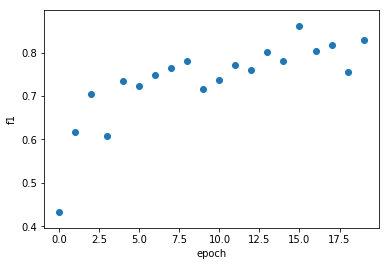

In [39]:


# get ranking plot for test set

#alpha_to_test = [1 - 5e-3, 1 - 1e-2, 1 - 5e-2, 1 - 1e-1, 1 - 4e-2]
alpha_to_test = [0.95]
factor_to_test = [2]

f1_ls = []

for t in factor_to_test:
    f1_ls.append(buildFeatureAndTrain(0.95,t))
    

    

Text(0.5,0,'factor multiplies std')

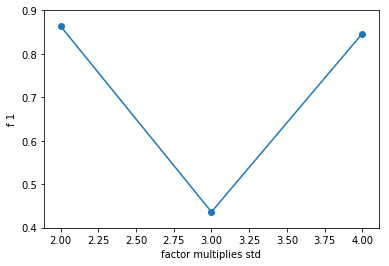

In [37]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
#ax1.scatter(rank_x,rank_y,s=4)
ax1.scatter(factor_to_test,f1_ls)
ax1.plot(factor_to_test,f1_ls)
ax1.set_ylabel('f 1')
ax1.set_xlabel('factor multiplies std')

In [ ]:
print(len(prediction))

In [ ]:
index_ls = []
tmp_count = 0
for i in range(maxLength):
    index_ls.append(tmp_count)
    tmp_count+=1

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.scatter(index_ls,prediction[0],s=4)

In [ ]:
print(np.histogram(np.array(prediction[0])))

In [ ]:
# 2*std + mean
precision = 0.8298045130227971
recall = 0.8766930195501624
f1 = 0.8526046012635594